In this notebook, Deep Neural Network hyperparameters will be tuned on the final feature dataframe. Final model parameters will be chosen based on the one which gives best ROC AUC metric.

## Importing libraries, modules and data

In [ ]:
# Importing the required libraries and modules
import os
import zipfile
import numpy as np
import pandas as pd
from datetime import datetime
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense,Layer,InputSpec,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.api._v2.keras import activations

from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.initializers import VarianceScaling

from sklearn import metrics
from sklearn.metrics import f1_score,classification_report,confusion_matrix,roc_curve,auc,precision_recall_curve,roc_curve
from tqdm import tqdm
!pip install kds
import kds
from IPython.display import Image

In [ ]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Importing the train test oot and train_smote dataframes
pickle_path = '/content/drive/MyDrive/Career/DS/Case Studies/Home Credit Default Risk/'

#1. X_train dataframe
pickle_in=open(pickle_path+"X_train_final.pickle","rb")
X_train=pickle.load(pickle_in)
pickle_in.close()
print("Shape of X_train dataframe is",X_train.shape)

#2. y_train dataframe
pickle_in=open(pickle_path+"y_train_final.pickle","rb")
y_train=pickle.load(pickle_in)
pickle_in.close()
print("Shape of y_train dataframe is",y_train.shape)

#3. X_train_smote dataframe
pickle_in=open(pickle_path+"X_train_smote_final.pickle","rb")
X_train_smote=pickle.load(pickle_in)
pickle_in.close()
print("Shape of X_train_smote dataframe is",X_train_smote.shape)

#4. y_train_smote dataframe
pickle_in=open(pickle_path+"y_train_smote_final.pickle","rb")
y_train_smote=pickle.load(pickle_in)
pickle_in.close()
print("Shape of y_train_smote dataframe is",y_train_smote.shape)

#5. X_test dataframe
pickle_in=open(pickle_path+"X_test_final.pickle","rb")
X_test=pickle.load(pickle_in)
pickle_in.close()
print("Shape of X_test dataframe is",X_test.shape)

#6. y_test dataframe
pickle_in=open(pickle_path+"y_test_final.pickle","rb")
y_test=pickle.load(pickle_in)
pickle_in.close()
print("Shape of y_test dataframe is",y_test.shape)

#7. X_oot dataframe
pickle_in=open(pickle_path+"X_oot_final.pickle","rb")
X_oot=pickle.load(pickle_in)
pickle_in.close()
print("Shape of X_oot dataframe is",X_oot.shape)

#8. y_oot dataframe
pickle_in=open(pickle_path+"y_oot_final.pickle","rb")
y_oot=pickle.load(pickle_in)
pickle_in.close()
print("Shape of y_oot dataframe is",y_oot.shape)

#9. X_test_oot dataframe
pickle_in=open(pickle_path+"X_test_oot_final.pickle","rb")
X_test_oot=pickle.load(pickle_in)
pickle_in.close()
print("Shape of X_test_oot dataframe is",X_test_oot.shape)

Shape of X_train dataframe is (246008, 15)
Shape of y_train dataframe is (246008,)
Shape of X_train_smote dataframe is (452272, 15)
Shape of y_train_smote dataframe is (452272,)
Shape of X_test dataframe is (30751, 15)
Shape of y_test dataframe is (30751,)
Shape of X_oot dataframe is (30752, 15)
Shape of y_oot dataframe is (30752,)
Shape of X_test_oot dataframe is (48744, 15)


## Model Functions

In [ ]:
def PlotConfusionMatrix(y_test,pred_test):
  cf=metrics.confusion_matrix(y_test,pred_test)

  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ['{0:0.0f}'.format(value) for value in cf.flatten()]
  group_percentages = ['{0:0.2%}'.format(value) for value in cf.flatten()/np.sum(cf)]
  labels=[f'{v1}\n{v2}\n{v3}' for v1,v2,v3 in zip(group_names,group_counts,group_percentages)]
  labels=np.asarray(labels).reshape(2,2)

  fig=plt.figure(figsize=(15,5))
  ax=fig.add_subplot(1,2,1)
  sns.heatmap(cf,cmap='crest',linewidth=0.5,annot=labels,fmt='',ax=ax)
  plt.title('Confusion Matrix')
  plt.ylabel('Real Classes')
  plt.xlabel('Predicted Classes')
  plt.show()

  accuracy = np.trace(cf) / float(np. sum(cf))
  precision = cf[1,1] / sum(cf[:,1])
  recall = cf[1,1]/sum(cf[1,:])
  f1_score = 2*precision*recall / (precision + recall)

  stats_text = "Accuracy={:0.5f}\nPrecision={:0.5f}\nRecall={:0.5f}\nF1 Score={:0.5F}".format(accuracy,precision,recall,f1_score)
  print("----------------Classification Report----------------")
  print(classification_report(y_test,pred_test))
  print("\n",'----------------Accuracy, precision, recall, f1_score----------------')
  print(stats_text)


In [ ]:
def decile_tablel(act,prob,round_decimal=10,change_deciles=10):
  qq=kds.metrics.decile_table(act,prob
                              ,round_decimal=round_decimal
                              ,change_deciles=change_deciles
                              ,labels=False)[['decile',
                                              'prob_min', 'prob_max',
                                              'cnt_cust', 'cnt_resp',
                                              'cnt_non_resp','cum_non_resp',
                                              'cum_resp', 'KS', 'lift']]
  qq["FP"]=round(qq['cnt_non_resp']/qq['cnt_resp'],2)
  qq["FP_cumm"]=round(qq['cum_non_resp']/qq['cnt_resp'],2)
  qq['prob_min']= round(qq['prob_min'], 6)
  qq['frd_cptr%'] = round(qq['cum_resp']/qq.cnt_resp.sum()*100,2)
  qq.columns = ['decile', 'prob_min', 'prob_max', 'ttl_customers', 'bad_customers','gd_customers', 'cum gd_customers',
                'cum_bad_customers', 'KS', 'Lift', 'FP', 'cum FP', 'default_captr%']
  return qq

In [ ]:
def ROC_curve_combined(actl_train,pred_train,actl_test,pred_test,actl_oot,pred_oot):
  print('Ploting the ROC Curve')
  fpr_train, tpr_train, thresholds =metrics.roc_curve(actl_train, pred_train)
  roc_auc_train = metrics.auc(fpr_train, tpr_train)*100 # compute area under the curve

  fpr_test, tpr_test, thresholds =metrics.roc_curve(actl_test, pred_test)
  roc_auc_test = metrics.auc(fpr_test, tpr_test)*100 # compute area under the curve

  fpr_oot, tpr_oot, thresholds =metrics.roc_curve(actl_oot, pred_oot)
  roc_auc_oot = metrics.auc(fpr_oot, tpr_oot)*100 # compute area under the curve

  plt.figure()
  plt.plot(fpr_train, tpr_train, label='Train ROC curve (area=%0.2f%%)' % (roc_auc_train))
  plt.plot(fpr_test, tpr_test, label='Test ROC curve (area=%0.2f%%)' % (roc_auc_test))
  plt.plot(fpr_oot, tpr_oot, label='OOT ROC curve (area=%0.2f%%)' % (roc_auc_oot))
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Bate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc= "lower right")
  plt.show()

## MLP model on Non SMOTE data:
Number of layers, hidden unit in each layer, dropout ratio are tuned by iterations on the non SMOTE data and following parameters are chosen based on the AUC value:

hidden_layer_units=[25,15,5]

no_hidden_layer=3

In [ ]:
# define the initializers
init=tf.keras.initializers.HeNormal() # weight initializer
act='relu' # activation function
# no_hidden_layer=7
# hidden_layer_units=[35,35,25,20,15,10,5]
# hidden_layer_units=[35,25,15,5]
# no_hidden_layer=4
hidden_layer_units=[25,15,5]
no_hidden_layer=3
input_data=Input(shape=(X_train_smote.shape[1],),name='input')
x=input_data
dropout=Dropout(0.05)(x)
for i in range(no_hidden_layer):
  x=Dense(hidden_layer_units[i],activation=act,kernel_initializer=init,name='layer_'+str(i+1))(dropout)
  dropout=Dropout(0.1)(x)

x=Dense(1,activation='sigmoid',kernel_initializer=init,name='layer_'+str(i+2))(x)
mlp_model=Model(inputs=input_data,outputs=x,name='mlp_model')
# compile the keras model
mlp_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['AUC'])

In [ ]:
mlp_model.summary()

Model: "mlp_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 15)]              0         
                                                                 
 dropout_38 (Dropout)        (None, 15)                0         
                                                                 
 layer_1 (Dense)             (None, 25)                400       
                                                                 
 dropout_39 (Dropout)        (None, 25)                0         
                                                                 
 layer_2 (Dense)             (None, 15)                390       
                                                                 
 dropout_40 (Dropout)        (None, 15)                0         
                                                                 
 layer_3 (Dense)             (None, 5)                 80

In [ ]:
# this pickle file was saved while tuning the parameters, lets import this and assess the performance
# mlp_model
pickle_in=open(pickle_path+"mlp_model_check274.pickle","rb")
mlp_model=pickle.load(pickle_in)
pickle_in.close()

In [ ]:
mlp_model.summary()

Model: "mlp_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 15)]              0         
                                                                 
 dropout_30 (Dropout)        (None, 15)                0         
                                                                 
 layer_1 (Dense)             (None, 25)                400       
                                                                 
 dropout_31 (Dropout)        (None, 25)                0         
                                                                 
 layer_2 (Dense)             (None, 15)                390       
                                                                 
 dropout_32 (Dropout)        (None, 15)                0         
                                                                 
 layer_3 (Dense)             (None, 5)                 80

In [ ]:
# #Fit the keras model on dataset
# mlp_model.fit(X_train_smote,y_train_smote,epochs=20,batch_size=8)
# #evaluate the keras model
# _,auc=mlp_model.evaluate(X_train,y_train)
# print('Train AUC : %.2f'%(auc*100))

Epoch 1/20
56534/56534 [==============================] - 106s 2ms/step - loss: 0.6409 - auc: 0.6869
Epoch 2/20
56534/56534 [==============================] - 108s 2ms/step - loss: 0.6367 - auc: 0.6935
Epoch 3/20
56534/56534 [==============================] - 107s 2ms/step - loss: 0.6338 - auc: 0.6980
Epoch 4/20
56534/56534 [==============================] - 106s 2ms/step - loss: 0.6319 - auc: 0.7013
Epoch 5/20
56534/56534 [==============================] - 105s 2ms/step - loss: 0.6308 - auc: 0.7031
Epoch 6/20
56534/56534 [==============================] - 107s 2ms/step - loss: 0.6291 - auc: 0.7055
Epoch 7/20
56534/56534 [==============================] - 107s 2ms/step - loss: 0.6292 - auc: 0.7061
Epoch 8/20
56534/56534 [==============================] - 105s 2ms/step - loss: 0.6279 - auc: 0.7075
Epoch 9/20
56534/56534 [==============================] - 106s 2ms/step - loss: 0.6272 - auc: 0.7088
Epoch 10/20
56534/56534 [==============================] - 107s 2ms/step - loss: 0.6271 - a

In [ ]:
# predicting the probabilities and class labels
mlp_proba_train_smote=mlp_model.predict(X_train_smote)
mlp_proba_train=mlp_model.predict(X_train)
mlp_proba_test=mlp_model.predict(X_test)
mlp_proba_oot=mlp_model.predict(X_oot)

# Threshold for class prediction based on the probability is decided by observations from decile tables
mlp_predict_train_smote=(mlp_proba_train_smote>0.16).astype(int)
mlp_predict_train=(mlp_proba_train>0.16).astype(int)
mlp_predict_test=(mlp_proba_test>0.16).astype(int)
mlp_predict_oot=(mlp_proba_oot>0.16).astype(int)

961/961 [==============================] - 3s 3ms/step


In [ ]:
pickle_path = '/content/drive/MyDrive/Career/DS/Case Studies/Home Credit Default Risk/'
pickle_out=open(pickle_path+'mlp_model_check274.pickle', 'wb')
pickle.dump(mlp_model,pickle_out)
pickle_out.close()

### ROC AUC

In [ ]:
### AUC estimation
# train SMOTE
fpr, tpr, threshold = metrics.roc_curve(y_train_smote,mlp_proba_train_smote)
roc_auc=metrics.auc(fpr,tpr)
print("Train SMOTE AUC is ",roc_auc)

# train
fpr, tpr, threshold = metrics.roc_curve(y_train,mlp_proba_train)
roc_auc=metrics.auc(fpr,tpr)
print("Train AUC is ",roc_auc)

# test
fpr, tpr, threshold = metrics.roc_curve(y_test,mlp_proba_test)
roc_auc=metrics.auc(fpr,tpr)
print("Test AUC is ",roc_auc)

# oot
fpr, tpr, threshold = metrics.roc_curve(y_oot,mlp_proba_oot)
roc_auc=metrics.auc(fpr,tpr)
print("OOT AUC is ",roc_auc)

Train SMOTE AUC is  0.7662745511546973
Train AUC is  0.741822862663068
Test AUC is  0.7425613433389603
OOT AUC is  0.7385033469899517


Ploting the ROC Curve


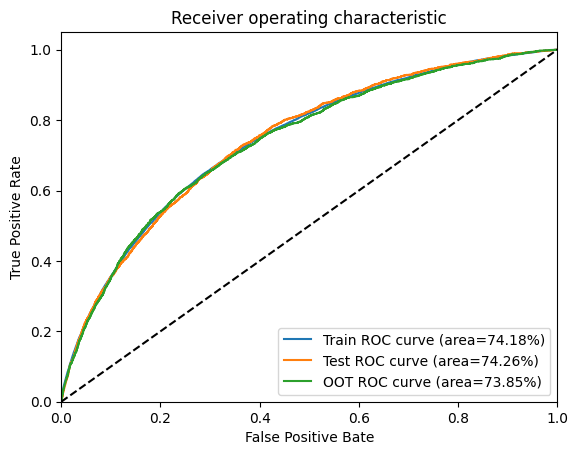

In [ ]:
ROC_curve_combined(y_train,mlp_proba_train,y_test,mlp_proba_test,y_oot,mlp_proba_oot)

### Confusion Matrix

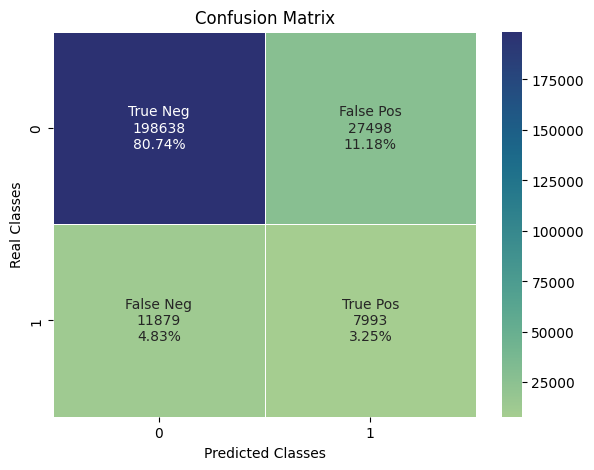

----------------Classification Report----------------
              precision    recall  f1-score   support

           0       0.94      0.88      0.91    226136
           1       0.23      0.40      0.29     19872

    accuracy                           0.84    246008
   macro avg       0.58      0.64      0.60    246008
weighted avg       0.89      0.84      0.86    246008


 ----------------Accuracy, precision, recall, f1_score----------------
Accuracy=0.83994
Precision=0.22521
Recall=0.40222
F1 Score=0.28875


In [ ]:
# Lets plot the confusion matrix
PlotConfusionMatrix(y_train,mlp_predict_train)

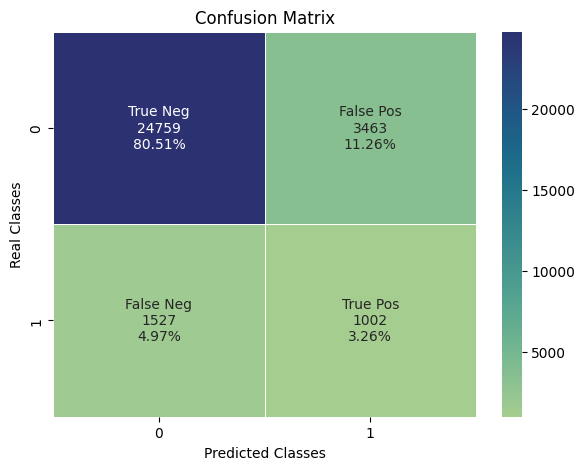

----------------Classification Report----------------
              precision    recall  f1-score   support

           0       0.94      0.88      0.91     28222
           1       0.22      0.40      0.29      2529

    accuracy                           0.84     30751
   macro avg       0.58      0.64      0.60     30751
weighted avg       0.88      0.84      0.86     30751


 ----------------Accuracy, precision, recall, f1_score----------------
Accuracy=0.83773
Precision=0.22441
Recall=0.39620
F1 Score=0.28653


In [ ]:
# Lets plot the confusion matrix
PlotConfusionMatrix(y_test,mlp_predict_test)

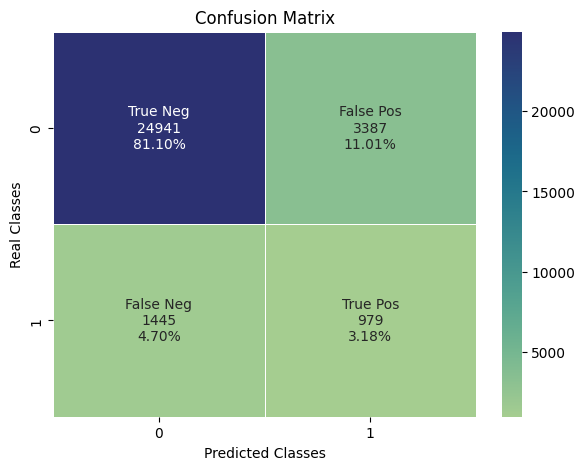

----------------Classification Report----------------
              precision    recall  f1-score   support

           0       0.95      0.88      0.91     28328
           1       0.22      0.40      0.29      2424

    accuracy                           0.84     30752
   macro avg       0.58      0.64      0.60     30752
weighted avg       0.89      0.84      0.86     30752


 ----------------Accuracy, precision, recall, f1_score----------------
Accuracy=0.84287
Precision=0.22423
Recall=0.40388
F1 Score=0.28837


In [ ]:
# Lets plot the confusion matrix
PlotConfusionMatrix(y_oot,mlp_predict_oot)

### Decile Table

In [ ]:
decile_tablel(y_train,mlp_proba_train,round_decimal=10,change_deciles=10)

,decile,prob_min,prob_max,ttl_customers,bad_customers,gd_customers,cum gd_customers,cum_bad_customers,KS,Lift,FP,cum FP,default_captr%
0,1,0.182661,0.536080,24601.0,6224.0,18377.0,18377.0,6224.0,23.193925,3.132020,2.95,2.95,31.32
1,2,0.138352,0.182659,24601.0,3649.0,20952.0,39329.0,9873.0,32.291224,2.484128,5.74,10.78,49.68
2,3,0.112356,0.138350,24601.0,2621.0,21980.0,61309.0,12494.0,35.760822,2.095729,8.39,23.39,62.87
3,4,0.092845,0.112355,24601.0,1936.0,22665.0,83974.0,14430.0,35.480443,1.815354,11.71,43.38,72.61
4,5,0.077411,0.092844,24600.0,1510.0,23090.0,107064.0,15940.0,32.868405,1.604267,15.29,70.90,80.21
5,6,0.064442,0.077411,24601.0,1261.0,23340.0,130404.0,17201.0,28.892794,1.442648,18.51,103.41,86.56
6,7,0.053079,0.064441,24601.0,972.0,23629.0,154033.0,18173.0,23.335077,1.306430,24.31,158.47,91.45
7,8,0.042879,0.053079,24601.0,769.0,23832.0,177865.0,18942.0,16.666052,1.191497,30.99,231.29,95.32
8,9,0.032890,0.042879,24601.0,580.0,24021.0,201886.0,19522.0,8.962363,1.091537,41.42,348.08,98.24
9,10,0.007570,0.032890,24600.0,350.0,24250.0,226136.0,19872.0,0.000000,1.000000,69.29,646.10,100.00


In [ ]:
decile_tablel(y_test,mlp_proba_test,round_decimal=10,change_deciles=10)

,decile,prob_min,prob_max,ttl_customers,bad_customers,gd_customers,cum gd_customers,cum_bad_customers,KS,Lift,FP,cum FP,default_captr%
0,1,0.183058,0.489244,3076.0,790.0,2286.0,2286.0,790.0,23.137580,3.122850,2.89,2.89,31.24
1,2,0.139384,0.183055,3075.0,434.0,2641.0,4927.0,1224.0,30.940565,2.419614,6.09,11.35,48.40
2,3,0.112652,0.139376,3075.0,345.0,2730.0,7657.0,1569.0,34.909016,2.067854,7.91,22.19,62.04
3,4,0.093420,0.112639,3075.0,281.0,2794.0,10451.0,1850.0,36.120049,1.828697,9.94,37.19,73.15
4,5,0.077923,0.093412,3075.0,197.0,2878.0,13329.0,2047.0,33.711971,1.618769,14.61,67.66,80.94
5,6,0.064579,0.077915,3075.0,152.0,2923.0,16252.0,2199.0,29.365084,1.449158,19.23,106.92,86.95
6,7,0.053123,0.064578,3075.0,133.0,2942.0,19194.0,2332.0,24.199588,1.317272,22.12,144.32,92.21
7,8,0.042732,0.053112,3075.0,90.0,2985.0,22179.0,2422.0,17.181452,1.197104,33.17,246.43,95.77
8,9,0.032901,0.042732,3075.0,65.0,3010.0,25189.0,2487.0,9.086200,1.092655,46.31,387.52,98.34
9,10,0.008855,0.032898,3075.0,42.0,3033.0,28222.0,2529.0,0.000000,1.000000,72.21,671.95,100.00


In [ ]:
decile_tablel(y_oot,mlp_proba_oot,round_decimal=10,change_deciles=10)

,decile,prob_min,prob_max,ttl_customers,bad_customers,gd_customers,cum gd_customers,cum_bad_customers,KS,Lift,FP,cum FP,default_captr%
0,1,0.182002,0.504063,3076.0,733.0,2343.0,2343.0,733.0,21.968305,3.023141,3.20,3.20,30.24
1,2,0.137718,0.182002,3075.0,487.0,2588.0,4931.0,1220.0,32.923227,2.516256,5.31,10.13,50.33
2,3,0.111726,0.137704,3075.0,292.0,2783.0,7714.0,1512.0,35.145229,2.079118,9.53,26.42,62.38
3,4,0.092767,0.111722,3075.0,233.0,2842.0,10556.0,1745.0,34.724964,1.799682,12.20,45.30,71.99
4,5,0.077062,0.092761,3075.0,175.0,2900.0,13456.0,1920.0,31.707215,1.584158,16.57,76.89,79.21
5,6,0.064167,0.077056,3076.0,173.0,2903.0,16359.0,2093.0,28.596367,1.439019,16.78,94.56,86.34
6,7,0.052722,0.064164,3075.0,115.0,2960.0,19319.0,2208.0,22.891566,1.301237,25.74,167.99,91.09
7,8,0.042587,0.052722,3075.0,98.0,2977.0,22296.0,2306.0,16.425433,1.189131,30.38,227.51,95.13
8,9,0.032558,0.042579,3075.0,71.0,3004.0,25300.0,2377.0,8.750127,1.089559,42.31,356.34,98.06
9,10,0.009652,0.032558,3075.0,47.0,3028.0,28328.0,2424.0,0.000000,1.000000,64.43,602.72,100.00


### Observations and Conclusion:
1. ROC AUC of 73.85% is achieved on the OOT data.
2. At 20% of the total transactions this model was able to capture around 50.33% of total defaulters.

## Predictions on the Kaggle Test dataset:

In [ ]:
# Merged Application test dataframe
pickle_in=open(pickle_path+"application_test_merged.pickle","rb")
application_test_merged=pickle.load(pickle_in)
pickle_in.close()
print("Shape of featurized Application test merged dataframe is",application_test_merged.shape)

Shape of featurized Application test merged dataframe is (48744, 1771)


In [ ]:
# Prediction on the application_test_merged dataframe
mlp_proba_test_oot=mlp_model.predict(X_test_oot)

1524/1524 [==============================] - 7s 5ms/step


In [ ]:
mlp_proba_test_oot[:,0]

array([0.07767014, 0.10371383, 0.05066317, ..., 0.05934884, 0.08559801,
       0.29719773], dtype=float32)

In [ ]:
# Preparing the dataframe to be submitted at Kaggle Submission
Mlpsol_kaggle=pd.DataFrame(application_test_merged['SK_ID_CURR'])
Mlpsol_kaggle['TARGET'] = pd.Series(mlp_proba_test_oot[:,0])
Mlpsol_kaggle

,SK_ID_CURR,TARGET
0,100001,0.077670
1,100005,0.103714
2,100013,0.050663
3,100028,0.043911
4,100038,0.193204
...,...,...
48739,456221,0.045059
48740,456222,0.107937
48741,456223,0.059349
48742,456224,0.085598


In [ ]:
# Lets save a dataframe as csv and upload the results on the kaggle submission
Mlpsol_kaggle.to_csv('/content/drive/MyDrive/Career/DS/Case Studies/Home Credit Default Risk/Mlpsol_kaggle.csv',index=False)

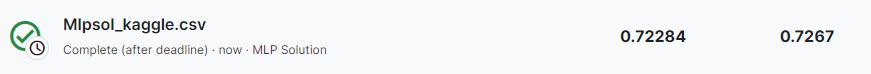

In [ ]:
Image(filename='/content/drive/MyDrive/Career/DS/Case Studies/Home Credit Default Risk/MLPKaggleResult.JPG',width=800,height=80)

### Observations about the kaggle solution submission:
ROC AUC of 72.28% is achieved on the kaggle test data for this model.